# Car prices prediction

## Intro

Our customer is a used car sales service that developes an application in order to attract new clients. The app helps to determine a market price of user's car.

Following criteria are essential for the customer:
* prediction quality
* time required for model trainig
* time required for prediction

**Objective** is to train a model with RMSE score under 2500

### Additional conditions
* use `LightBGM` library for gradient boosting
* use at least one non-GB model
* determine evaluation time for JupyterNB cells

### Dataset description

Dataset objects are entries crawled from car profile forms:

* `DateCrawled` — date the form was downloaded on from a database
* `VehicleType` — car body type
* `RegistrationYear` — year of car registration
* `Gearbox` — gearbox type
* `Power` — horsepower (hp)
* `Model` — car model
* `Kilometer` — car mileage (km)
* `RegistrationMonth` — month of car registration
* `FuelType` — fuel type
* `Brand` — car brand
* `Repaired` — was the car in repair or not
* `DateCreated` — car profile creation date
* `NumberOfPictures` — number of car photos
* `PostalCode` — postal code of a user who owns a car profile
* `LastSeen` — last user activity date

Target feature:
* `Price` — price (euro)

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

We will use `ydata-profiling` library for EDA: https://github.com/ydataai/ydata-profiling.

In [2]:
from ydata_profiling import ProfileReport

### Globals

In [3]:
PATH_TO_DATA = './datasets/autos.csv' # path to dataset
RND = 1337 # randon state

## Open data and EDA

In [18]:
df = pd.read_csv(PATH_TO_DATA)
display(df.head(3), df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46


None

We will profile data using `ProfileReport` object

In [5]:
# ydata_profiling
profile = ProfileReport(df, title="Autos")

In [6]:
# we'll put report output in a different cell
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

Let's check alerts the report provided us with

### Data cleaning

#### Constant

Column `NumberOfPictures` has constant value

In [19]:
df['NumberOfPictures'].unique()

array([0], dtype=int64)

This column bears no information so we will drop it

In [20]:
df = df.drop(columns=['NumberOfPictures'])
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'PostalCode', 'LastSeen'],
      dtype='object')

#### Duplicates

The dataset has 4 fully duplicated rows so we will drop them

In [21]:
df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

#### High cardinality

Columns `DateCrawled`, `DateCreated`, `LastSeen` have no impact on target feature since they are not related to cars themselves but to database operation. We will drop those columns.

In [22]:
df = df.drop(columns=['DateCrawled', 'DateCreated', 'LastSeen'])
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode'],
      dtype='object')

Column `Model` is reported to have high cardinality too but this data could be important for target.

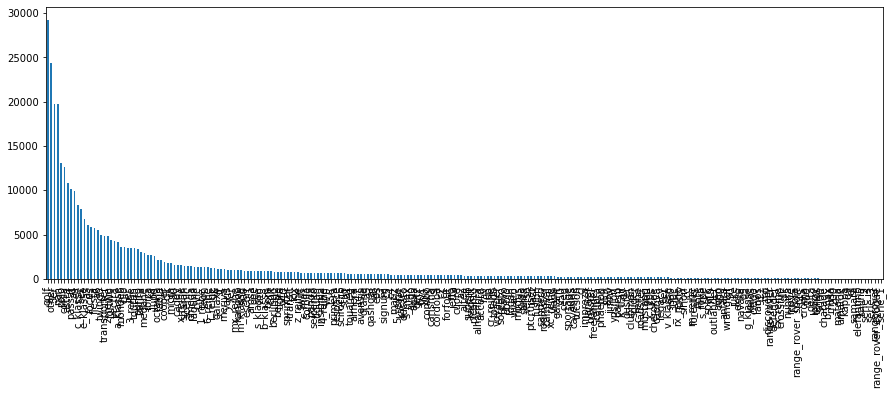

In [56]:
# checking value counts
model_counts = df['Model'].value_counts(dropna=False)
model_counts.plot(kind='bar', figsize=(15, 5))
plt.show()

In [193]:
model_counts.head(50)

golf           29232
other          24420
3er            19761
NaN            19705
polo           13066
corsa          12570
astra          10809
passat         10145
a4              9900
c_klasse        8312
5er             7868
e_klasse        6785
a3              6122
focus           5874
fiesta          5774
a6              5541
twingo          4953
transporter     4822
2_reihe         4816
fortwo          4337
vectra          4254
a_klasse        4193
mondeo          3601
clio            3546
1er             3514
3_reihe         3493
touran          3470
punto           3347
zafira          3044
megane          2910
ibiza           2702
ka              2702
lupo            2594
octavia         2108
fabia           2080
cooper          1950
clk             1828
micra           1758
80              1604
caddy           1595
x_reihe         1589
sharan          1483
scenic          1446
omega           1416
laguna          1364
civic           1347
1_reihe         1306
leon         

We will check brand-model pairs

In [121]:
model_brand = df.groupby(by=['Brand', 'Model'], dropna=False)

In [155]:
model_brand[['Gearbox', 'Power', 'FuelType', 'VehicleType']].agg('nunique')

Gearbox  Power  FuelType  VehicleType
Brand      Model                                          
alfa_romeo 145             1     14         2            4
           147             2     25         3            6
           156             2     36         3            5
           159             2     18         2            2
           other           2     68         3            6
...                      ...    ...       ...          ...
volvo      v50             2     15         4            2
           v60             2     13         3            2
           v70             2     49         4            2
           xc_reihe        2     25         3            3
           NaN             2     31         4            4

[337 rows x 4 columns]

In [174]:
df[(df['Brand'] == 'alfa_romeo') & (df['Model'] == '145')].value_counts(subset='VehicleType', dropna=False)

VehicleType
small    19
NaN      14
sedan    13
coupe     2
other     1
dtype: int64

Although `Brand` and `Model` define a car there are dufferent

In [159]:
df['VehicleType'].value_counts(dropna=False)

sedan          91457
small          79830
wagon          65165
NaN            37490
bus            28775
convertible    20203
coupe          16161
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [160]:
model_group = df.groupby(by='Model', dropna=False)

In [162]:
model_group['Price'].agg('count')

Model
100          417
145           49
147          572
156          629
159          212
           ...  
yeti         174
ypsilon      209
z_reihe      717
zafira      3044
NaN        19705
Name: Price, Length: 251, dtype: int64

In [190]:
df['ModelsCount'] = df.groupby(by='Model', dropna=False)['Price'].transform('count')

In [191]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,ModelsCount
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435,29232
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954,19705
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480,561
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074,29232
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437,2080


In [192]:
df.query('Brand == "audi"')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,ModelsCount
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954,19705
61,7499,sedan,2004,auto,232,a8,150000,3,gasoline,audi,yes,71711,529
90,2400,sedan,2003,manual,0,a4,150000,9,gasoline,audi,NaN,40210,9900
93,14500,small,2013,manual,86,a1,60000,4,petrol,audi,no,31582,595
100,499,sedan,1995,manual,101,a4,150000,5,petrol,audi,NaN,85414,9900
...,...,...,...,...,...,...,...,...,...,...,...,...,...
354304,850,sedan,1989,manual,113,80,150000,3,petrol,audi,yes,9127,1604
354306,16999,wagon,2008,auto,269,a6,150000,7,gasoline,audi,no,61440,5541
354344,1600,wagon,1998,manual,125,a4,150000,2,petrol,audi,no,34414,9900
354349,5999,wagon,2005,manual,140,a4,150000,4,gasoline,audi,NaN,56472,9900
